# Wikidata Archaeological Sites in Chieti as Map

This notebook fetches archaeological sites using a SPARQL query from Wikidata and creates maps.

## Define SPARQL query service

In [15]:
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx  # For adding OpenStreetMap basemaps
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
import numpy as np

def querySparql(query):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    return results['results']['bindings']

## Define the SPARQL Query

In [16]:
# SPARQL Query
sitesQuery = """
SELECT DISTINCT ?item ?itemLabel ?geo ?img WHERE {
 ?item (wdt:P31/(wdt:P279*)) wd:Q839954.
 ?item wdt:P17 wd:Q38.
 ?item wdt:P131 wd:Q13138.
 ?item wdt:P625 ?geo.
 OPTIONAL { ?item wdt:P18 ?img }
 SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
"""

## Fetch Data and Convert to DataFrame

In [17]:
# Fetch data using the SPARQL query
sparql_results = querySparql(sitesQuery)

# Convert SPARQL JSON results into a DataFrame
data = []
for result in sparql_results:
    geo = result['geo']['value'] if 'geo' in result else None
    lat, lon = (None, None)
    if geo:
        lon, lat = map(float, geo.replace("Point(", "").replace(")", "").split())
    data.append({
        "item": result['item']['value'],
        "itemLabel": result['itemLabel']['value'],
        "latitude": lat,
        "longitude": lon,
    })

df = pd.DataFrame(data)
df

,item,itemLabel,latitude,longitude
0,http://www.wikidata.org/entity/Q55685833,Chieti Roman theatre,42.347124,14.163451
1,http://www.wikidata.org/entity/Q3554226,Teate,42.346992,14.168101
2,http://www.wikidata.org/entity/Q28978015,Teate Marrucinorum amphitheatre,42.345025,14.162539
3,http://www.wikidata.org/entity/Q3867665,Archeological Museum La Civitella,42.345096,14.162026


## Visualise the Data in a map

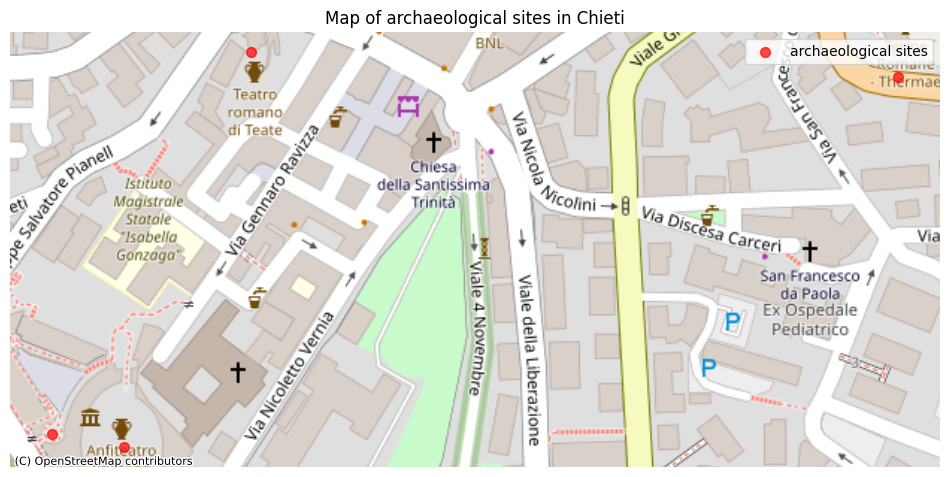

In [18]:
# Check if DataFrame is populated
if df.empty:
    print("No data retrieved from the query.")
else:
    # Filter rows with valid coordinates
    df_with_coords = df.dropna(subset=['latitude', 'longitude'])

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df_with_coords,
        geometry=[Point(xy) for xy in zip(df_with_coords['longitude'], df_with_coords['latitude'])],
        crs="EPSG:4326"
    )

    # Convert to Web Mercator for OSM basemap
    gdf_mercator = gdf.to_crs(epsg=3857)

    # Plot points on the map
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf_mercator.plot(ax=ax, color='red', markersize=50, alpha=0.7, label="archaeological sites")
    
    # Add OSM basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    ax.set_axis_off()
    plt.title("Map of archaeological sites in Chieti")
    plt.legend()
    plt.show()